lets download in-shop dataset

> https://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/InShopRetrieval.html




In [ ]:
# !gdown 0B7EVK8r0v71pS2YxRE1QTFZzekU

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pS2YxRE1QTFZzekU

but Gdown can't. Please check connections and permissions.


In [1]:
!gdown 1ivJOdZj2GHlZxRiHzr-_RTZRrZnMo-7l

Downloading...
From (original): https://drive.google.com/uc?id=1ivJOdZj2GHlZxRiHzr-_RTZRrZnMo-7l
From (redirected): https://drive.google.com/uc?id=1ivJOdZj2GHlZxRiHzr-_RTZRrZnMo-7l&confirm=t&uuid=d832a9fe-2deb-4a7a-b7c3-5df2976df366
To: /workspace/test/img.zip
100%|████████████████████████████████████████| 831M/831M [00:25<00:00, 33.0MB/s]


In [ ]:
!unzip img.zip

In [3]:
import glob

data = glob.glob('img/**/*.jpg', recursive=True)
data[:5]

['img/WOMEN/Tees_Tanks/id_00007981/03_7_additional.jpg',
 'img/WOMEN/Tees_Tanks/id_00007981/03_3_back.jpg',
 'img/WOMEN/Tees_Tanks/id_00007981/03_1_front.jpg',
 'img/WOMEN/Tees_Tanks/id_00007979/04_7_additional.jpg',
 'img/WOMEN/Tees_Tanks/id_00007979/04_4_full.jpg']

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

def plot_image_strip(image_paths, figsize=(15, 3), imsize=None, titles=None, gap=0.01):
    """
    Plot multiple images in a horizontal strip.

    Args:
        image_paths (list): List of paths to images
        figsize (tuple): Figure size (width, height)
        imsize (tuple): Optional size to resize images to (width, height)
        titles (list): Optional list of titles for each image
        gap (float): Gap between images (as fraction of figure width)

    Returns:
        fig: matplotlib figure object
    """
    n_images = len(image_paths)

    # Create figure
    fig = plt.figure(figsize=figsize)

    # Calculate subplot positions considering gaps
    total_gap_space = gap * (n_images - 1)
    width_per_image = (1.0 - total_gap_space) / n_images

    for i, path in enumerate(image_paths):
        # Read and process image
        try:
            img = Image.open(path)
            if imsize:
                img = img.resize(imsize, Image.Resampling.LANCZOS)
            img = np.array(img)

            # Calculate subplot position
            left = i * (width_per_image + gap)

            # Create subplot
            ax = fig.add_axes([left, 0, width_per_image, 1])

            # Display image
            ax.imshow(img)
            ax.axis('off')

            # Add title if provided
            if titles and i < len(titles):
                ax.set_title(titles[i], pad=10)

        except Exception as e:
            print(f"Error loading image {path}: {str(e)}")
            continue

    plt.close()
    return fig

# Example usage function
def example_usage():
    # Sample image paths
    image_paths = data[:5]

    # Basic usage
    fig = plot_image_strip(image_paths)
    fig.show()


example_usage()

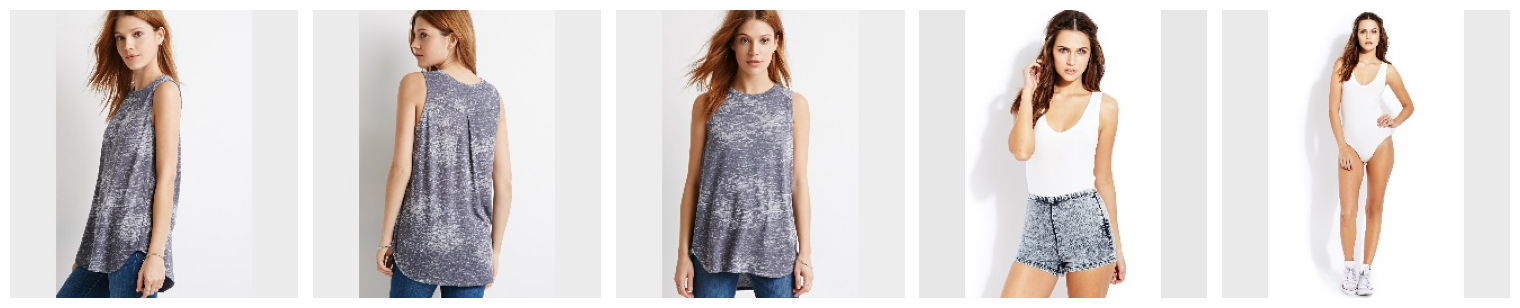

In [5]:
plot_image_strip(data[:5], figsize=(15, 3), imsize=None, titles=None, gap=0.01)

now, lets try different models for embedding

In [7]:
# openai/clip-vit-large-patch14-
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 777.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
import torch
import torchvision.transforms as T
from torchvision.models import resnet50, resnet18, mobilenet_v3_large, efficientnet_b0
from PIL import Image
import timm
from transformers import ViTForImageClassification, CLIPProcessor, CLIPModel
import numpy as np

class EmbeddingExtractor:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.models = {}
        self.transforms = {}

    def get_transform(self, model_name):
        """Get standard transformation for each model"""
        if model_name in self.transforms:
            return self.transforms[model_name]

        basic_transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
        ])

        if model_name == 'clip':
            return self.models[model_name][0]  # CLIP processor

        return basic_transform

    def load_resnet50(self):
        """Load ResNet50 model"""
        model = resnet50(pretrained=True)
        model.fc = torch.nn.Identity()  # Remove classification layer
        model = model.to(self.device)
        model.eval()
        self.models['resnet50'] = model
        self.transforms['resnet50'] = self.get_transform('resnet50')

    def load_resnet18(self):
        """Load ResNet18 model"""
        model = resnet18(pretrained=True)
        model.fc = torch.nn.Identity()
        model = model.to(self.device)
        model.eval()
        self.models['resnet18'] = model
        self.transforms['resnet18'] = self.get_transform('resnet18')

    def load_mobilenetv3(self):
        """Load MobileNetV3 model"""
        model = mobilenet_v3_large(pretrained=True)
        model.classifier[-1] = torch.nn.Identity()
        model = model.to(self.device)
        model.eval()
        self.models['mobilenetv3'] = model
        self.transforms['mobilenetv3'] = self.get_transform('mobilenetv3')

    def load_efficientnet(self):
        """Load EfficientNet model"""
        model = efficientnet_b0(pretrained=True)
        model.classifier = torch.nn.Identity()
        model = model.to(self.device)
        model.eval()
        self.models['efficientnet'] = model
        self.transforms['efficientnet'] = self.get_transform('efficientnet')

    def load_vit(self):
        """Load ViT model"""
        model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            output_hidden_states=True,
            output_attentions=True
        )
        model = model.to(self.device)
        model.eval()
        self.models['vit'] = model
        self.transforms['vit'] = self.get_transform('vit')

    def load_clip(self):
        """Load CLIP model"""
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        model = model.to(self.device)
        model.eval()
        self.models['clip'] = (processor, model)
        self.transforms['clip'] = processor

    def extract_embedding(self, image_path, model_name):
        """
        Extract embedding from image using specified model

        Args:
            image_path (str): Path to image file
            model_name (str): Name of model to use

        Returns:
            numpy.ndarray: Image embedding
        """
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not loaded")

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')

        with torch.no_grad():
            if model_name == 'clip':
                processor, model = self.models['clip']
                inputs = processor(images=image, return_tensors="pt").to(self.device)
                embedding = model.get_image_features(**inputs)
            elif model_name == 'vit':
                transform = self.transforms[model_name]
                input_tensor = transform(image).unsqueeze(0).to(self.device)
                outputs = self.models[model_name](input_tensor, output_hidden_states=True)
                # Get the [CLS] token embedding from the last layer
                embedding = outputs.hidden_states[-1][:, 0, :]
            else:
                transform = self.transforms[model_name]
                input_tensor = transform(image).unsqueeze(0).to(self.device)
                embedding = self.models[model_name](input_tensor)

        return embedding.cpu().detach().numpy()

    def extract_embeddings_batch(self, image_paths, model_name, batch_size=32):
        """
        Extract embeddings from multiple images in batches

        Args:
            image_paths (list): List of image paths
            model_name (str): Name of model to use
            batch_size (int): Batch size for processing

        Returns:
            numpy.ndarray: Array of embeddings
        """
        embeddings = []

        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_embeddings = [
                self.extract_embedding(path, model_name)
                for path in batch_paths
            ]
            embeddings.extend(batch_embeddings)

        return np.vstack(embeddings)


# Example usage
def example_usage():
    # Initialize extractor
    extractor = EmbeddingExtractor()

    # Load desired models
    extractor.load_resnet50()
    extractor.load_resnet18()
    extractor.load_mobilenetv3()
    extractor.load_clip()
    extractor.load_efficientnet()
    extractor.load_vit()

    # Extract embeddings for single image
    image_path = data[0]
    print(image_path)
    resnet50_embedding = extractor.extract_embedding(image_path, 'resnet50')
    mobilenet_embedding = extractor.extract_embedding(image_path, 'mobilenetv3')
    clip_embedding = extractor.extract_embedding(image_path, 'clip')
    vit_embedding = extractor.extract_embedding(image_path, 'vit')
    efficient_embedding = extractor.extract_embedding(image_path, 'efficientnet')
    resnet18_embedding = extractor.extract_embedding(image_path, 'resnet18')

    # Extract embeddings for multiple images
    image_paths = data[:5]
    batch_embeddings = extractor.extract_embeddings_batch(
        image_paths,
        'resnet50',
        batch_size=32
    )

    return {
        'resnet50': resnet50_embedding.shape,
        'mobilenet': mobilenet_embedding.shape,
        'clip': clip_embedding.shape,
        'vit': vit_embedding.shape,
        'efficient': efficient_embedding.shape,
        'resnet18': resnet18_embedding.shape,
        'batch': batch_embeddings.shape
    }

In [9]:
example_usage()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s] 
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 79.8MB/s]


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

img/WOMEN/Tees_Tanks/id_00007981/03_7_additional.jpg


`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


{'resnet50': (1, 2048),
 'mobilenet': (1, 1280),
 'clip': (1, 512),
 'vit': (1, 768),
 'efficient': (1, 1280),
 'resnet18': (1, 512),
 'batch': (5, 2048)}

extract and save embeddings

In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import os
from typing import List, Dict

def process_embeddings(
    image_paths: List[str],
    model_name: str,
    extractor,
    batch_size: int = 32,
    save_path: str = None
) -> pd.DataFrame:
    """
    Process images and save embeddings to parquet file.

    Args:
        image_paths: List of image paths
        model_name: Name of the model to use
        extractor: EmbeddingExtractor instance
        batch_size: Batch size for processing
        save_path: Path to save the parquet file
    """
    all_embeddings = []

    # Process images in batches with progress bar
    for i in tqdm(range(0, len(image_paths), batch_size), desc=f"Processing {model_name}"):
        batch_paths = image_paths[i:i + batch_size]
        try:
            batch_embeddings = extractor.extract_embeddings_batch(
                batch_paths,
                model_name,
                batch_size
            )
            all_embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"Error processing batch starting at {i}: {str(e)}")
            # Fill failed embeddings with zeros
            failed_embeddings = [
                np.zeros((1, extractor.models[model_name].get_embedding_dim()))
                for _ in range(len(batch_paths))
            ]
            all_embeddings.extend(failed_embeddings)

    # Create DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        f'{model_name}_embedding': all_embeddings
    })

    # Save to parquet if path provided
    if save_path:
        df.to_parquet(save_path, index=False)
        print(f"Saved embeddings to {save_path}")

    return df

# Example usage for each model
def main():
    # Get image paths
    data = glob.glob('img/**/*.jpg', recursive=True)
    print(f"Found {len(data)} images")

    # Initialize extractor
    extractor = EmbeddingExtractor()

    # Create output directory
    os.makedirs('embeddings', exist_ok=True)

    # Process ResNet50
    extractor.load_resnet50()
    resnet_df = process_embeddings(
        data,
        'resnet50',
        extractor,
        save_path='embeddings/resnet50_embeddings.parquet'
    )

    # Process ResNet18
    extractor.load_resnet18()
    resnet18_df = process_embeddings(
        data,
        'resnet18',
        extractor,
        save_path='embeddings/resnet18_embeddings.parquet'
    )

    # Process MobileNetV3
    extractor.load_mobilenetv3()
    mobilenet_df = process_embeddings(
        data,
        'mobilenetv3',
        extractor,
        save_path='embeddings/mobilenetv3_embeddings.parquet'
    )

    # Process EfficientNet
    extractor.load_efficientnet()
    efficientnet_df = process_embeddings(
        data,
        'efficientnet',
        extractor,
        save_path='embeddings/efficientnet_embeddings.parquet'
    )

    # Process ViT
    extractor.load_vit()
    vit_df = process_embeddings(
        data,
        'vit',
        extractor,
        save_path='embeddings/vit_embeddings.parquet'
    )

    # Process CLIP
    extractor.load_clip()
    clip_df = process_embeddings(
        data,
        'clip',
        extractor,
        save_path='embeddings/clip_embeddings.parquet'
    )

    # Optional: Merge all embeddings into single DataFrame
    dfs = [resnet_df,resnet18_df, mobilenet_df, efficientnet_df, vit_df, clip_df]
    merged_df = pd.concat([df.set_index('image_path') for df in dfs], axis=1)
    merged_df.to_parquet('embeddings/all_embeddings.parquet')

    print("Completed processing all models!")


In [ ]:
main()

Found 52712 images


Processing resnet50: 100%|██████████| 1648/1648 [07:59<00:00,  3.44it/s]


Saved embeddings to embeddings/resnet50_embeddings.parquet


Processing resnet18: 100%|██████████| 1648/1648 [04:35<00:00,  5.98it/s]


Saved embeddings to embeddings/resnet18_embeddings.parquet


Processing mobilenetv3: 100%|██████████| 1648/1648 [08:05<00:00,  3.39it/s]


Saved embeddings to embeddings/mobilenetv3_embeddings.parquet


Processing efficientnet: 100%|██████████| 1648/1648 [09:52<00:00,  2.78it/s]


Saved embeddings to embeddings/efficientnet_embeddings.parquet


Processing vit: 100%|██████████| 1648/1648 [15:02<00:00,  1.83it/s]


Saved embeddings to embeddings/vit_embeddings.parquet


Processing clip: 100%|██████████| 1648/1648 [09:32<00:00,  2.88it/s]


Saved embeddings to embeddings/clip_embeddings.parquet
Completed processing all models!


In [ ]:
merged_df = pd.read_parquet('embeddings/all_embeddings.parquet')
merged_df.head()

,resnet50_embedding,resnet18_embedding,mobilenetv3_embedding,efficientnet_embedding,vit_embedding,clip_embedding
image_path,,,,,,
img/WOMEN/Dresses/id_00004241/03_4_full.jpg,"[0.4602317, 0.06862857, 0.88332576, 0.38104084...","[0.5243838, 0.77826923, 0.13453962, 0.3470885,...","[0.2821547, 0.30583873, -0.0, 0.07783736, -0.1...","[0.78348947, -0.18125089, -0.07680486, -0.1198...","[2.7296338, -3.8618956, 8.480946, -4.1722913, ...","[-0.36900735, -0.24437469, -0.17975047, 0.4581..."
img/WOMEN/Dresses/id_00004241/03_3_back.jpg,"[0.18023624, 0.076868005, 1.6299282, 0.1574512...","[0.40578592, 0.76809263, 0.36371142, 0.6259420...","[0.23806277, 0.7084515, -0.0, -0.09592518, -0....","[1.4680914, -0.11241371, -0.05939392, -0.10255...","[4.951768, 3.1798973, 7.6340985, -5.8456745, 9...","[-0.36915332, -0.20680368, 0.16405793, 0.30153..."
img/WOMEN/Dresses/id_00004241/03_2_side.jpg,"[0.22528665, 0.29955, 1.4728853, 0.23574679, 0...","[0.40803275, 0.13298017, 0.037551258, 0.323384...","[0.2915824, 0.8161652, -0.23109591, -0.27154, ...","[0.9370599, 0.047927864, 0.026802203, -0.08407...","[1.8554788, -0.945738, 4.761429, -6.617939, 6....","[-0.28507307, -0.23734331, -0.10224485, 0.6539..."
img/WOMEN/Dresses/id_00004241/04_2_side.jpg,"[0.064413935, 0.06409776, 0.9420228, 0.0539363...","[0.4344536, 0.4527555, 0.060901787, 0.64014673...","[1.6039009, 1.8672836, -0.0, 0.30171275, -0.06...","[1.120947, -0.102119826, -0.062766135, -0.0945...","[-4.65253, 2.532223, 0.47912914, -1.6363356, 1...","[-0.32756314, -0.34851646, -0.25114128, 0.4278..."
img/WOMEN/Dresses/id_00004241/03_1_front.jpg,"[0.32238325, 0.22012426, 1.3985032, 0.21699062...","[0.27906218, 0.88454163, 0.04622143, 0.3649924...","[-0.3654459, 0.58490855, -0.0, 0.008051937, -0...","[0.99836767, -0.12037434, -0.11105428, -0.0998...","[0.15834796, 0.8337013, 4.1631327, 1.1089685, ...","[-0.2640978, -0.43451828, -0.06390861, 0.25978..."


In [ ]:
filepath = '/content/list_eval_partition.txt'
file = open(filepath, 'r')

lines = file.readlines()

eval_data = []
for line in lines:
    parts = line.strip().split()
    image_path = parts[0]
    item_id = parts[1]
    evaluation_status = parts[2]
    eval_data.append([image_path, item_id, evaluation_status])

eval_df = pd.DataFrame(eval_data[1:], columns=['image_path', 'item_id', 'evaluation_status'])

eval_df.head()

,image_path,item_id,evaluation_status
0,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,id_00000002,train
1,img/WOMEN/Dresses/id_00000002/02_2_side.jpg,id_00000002,train
2,img/WOMEN/Dresses/id_00000002/02_4_full.jpg,id_00000002,train
3,img/WOMEN/Dresses/id_00000002/02_7_additional.jpg,id_00000002,train
4,img/WOMEN/Skirts/id_00000003/02_1_front.jpg,id_00000003,train


In [ ]:
eval_df#[eval_df['evaluation_status']!='train']

,image_path,item_id,evaluation_status
0,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,id_00000002,train
1,img/WOMEN/Dresses/id_00000002/02_2_side.jpg,id_00000002,train
2,img/WOMEN/Dresses/id_00000002/02_4_full.jpg,id_00000002,train
3,img/WOMEN/Dresses/id_00000002/02_7_additional.jpg,id_00000002,train
4,img/WOMEN/Skirts/id_00000003/02_1_front.jpg,id_00000003,train
...,...,...,...
52707,img/WOMEN/Jackets_Coats/id_00007982/12_7_addit...,id_00007982,gallery
52708,img/WOMEN/Jackets_Coats/id_00007982/13_1_front...,id_00007982,query
52709,img/WOMEN/Jackets_Coats/id_00007982/13_2_side.jpg,id_00007982,gallery
52710,img/WOMEN/Jackets_Coats/id_00007982/13_3_back.jpg,id_00007982,query


In [ ]:
merged_df = merged_df.merge(eval_df, on='image_path', how='left')
merged_df.head()
merged_df.to_parquet('embeddings/all_embeddings_evalstatus.parquet')

In [ ]:
merged_df

,image_path,resnet50_embedding,resnet18_embedding,mobilenetv3_embedding,efficientnet_embedding,vit_embedding,clip_embedding,item_id_x,evaluation_status_x,item_id_y,evaluation_status_y
0,img/WOMEN/Dresses/id_00004241/03_4_full.jpg,"[0.4602317, 0.06862857, 0.88332576, 0.38104084...","[0.5243838, 0.77826923, 0.13453962, 0.3470885,...","[0.2821547, 0.30583873, -0.0, 0.07783736, -0.1...","[0.78348947, -0.18125089, -0.07680486, -0.1198...","[2.7296338, -3.8618956, 8.480946, -4.1722913, ...","[-0.36900735, -0.24437469, -0.17975047, 0.4581...",id_00004241,train,id_00004241,train
1,img/WOMEN/Dresses/id_00004241/03_3_back.jpg,"[0.18023624, 0.076868005, 1.6299282, 0.1574512...","[0.40578592, 0.76809263, 0.36371142, 0.6259420...","[0.23806277, 0.7084515, -0.0, -0.09592518, -0....","[1.4680914, -0.11241371, -0.05939392, -0.10255...","[4.951768, 3.1798973, 7.6340985, -5.8456745, 9...","[-0.36915332, -0.20680368, 0.16405793, 0.30153...",id_00004241,train,id_00004241,train
2,img/WOMEN/Dresses/id_00004241/03_2_side.jpg,"[0.22528665, 0.29955, 1.4728853, 0.23574679, 0...","[0.40803275, 0.13298017, 0.037551258, 0.323384...","[0.2915824, 0.8161652, -0.23109591, -0.27154, ...","[0.9370599, 0.047927864, 0.026802203, -0.08407...","[1.8554788, -0.945738, 4.761429, -6.617939, 6....","[-0.28507307, -0.23734331, -0.10224485, 0.6539...",id_00004241,train,id_00004241,train
3,img/WOMEN/Dresses/id_00004241/04_2_side.jpg,"[0.064413935, 0.06409776, 0.9420228, 0.0539363...","[0.4344536, 0.4527555, 0.060901787, 0.64014673...","[1.6039009, 1.8672836, -0.0, 0.30171275, -0.06...","[1.120947, -0.102119826, -0.062766135, -0.0945...","[-4.65253, 2.532223, 0.47912914, -1.6363356, 1...","[-0.32756314, -0.34851646, -0.25114128, 0.4278...",id_00004241,train,id_00004241,train
4,img/WOMEN/Dresses/id_00004241/03_1_front.jpg,"[0.32238325, 0.22012426, 1.3985032, 0.21699062...","[0.27906218, 0.88454163, 0.04622143, 0.3649924...","[-0.3654459, 0.58490855, -0.0, 0.008051937, -0...","[0.99836767, -0.12037434, -0.11105428, -0.0998...","[0.15834796, 0.8337013, 4.1631327, 1.1089685, ...","[-0.2640978, -0.43451828, -0.06390861, 0.25978...",id_00004241,train,id_00004241,train
...,...,...,...,...,...,...,...,...,...,...,...
52707,img/MEN/Shorts/id_00001350/01_3_back.jpg,"[0.04948402, 0.50594634, 0.37573346, 0.3278176...","[0.47963437, 1.2487897, 0.44249842, 0.8130967,...","[-0.2422956, 0.092452064, -0.0, 0.4944341, -0....","[1.2558235, -0.14215256, -0.08976871, -0.14236...","[-9.4469385, 11.531136, 4.2499485, -10.634777,...","[0.21059868, -0.25725764, 0.29774776, 0.362632...",id_00001350,query,id_00001350,query
52708,img/MEN/Shorts/id_00001350/01_2_side.jpg,"[0.12622637, 0.69567215, 0.6594954, 0.19040045...","[1.0494486, 0.6887088, 0.08578127, 0.06881114,...","[0.12699676, -0.37482077, -0.2353236, 0.292762...","[1.3591654, -0.15632239, -0.06211529, -0.12718...","[-5.146437, 11.044399, 3.5826447, -6.7096267, ...","[-0.11613632, -0.37073582, 0.19343618, 0.39620...",id_00001350,query,id_00001350,query
52709,img/MEN/Shorts/id_00001350/01_1_front.jpg,"[0.12723923, 0.7532906, 0.53551155, 0.24811329...","[0.5359174, 1.306491, 0.53830016, 0.46408767, ...","[-0.33543783, 0.020486984, -0.2813424, 0.68362...","[0.65963435, -0.16563372, -0.05293927, -0.1477...","[-3.7560644, 8.071529, 6.3767195, -6.9959946, ...","[0.11420332, -0.23990758, 0.24858885, 0.638019...",id_00001350,gallery,id_00001350,gallery
52710,img/MEN/Shorts/id_00001350/01_4_full.jpg,"[0.2249466, 0.67623246, 0.4107361, 0.25931433,...","[0.4914844, 1.4188092, 0.23311584, 0.5536278, ...","[-0.012841819, -0.06941959, -0.27538818, 0.025...","[0.4302676, -0.11948377, -0.03621048, -0.14620...","[-1.3989038, 8.969146, 3.2788165, -5.404677, 2...","[-0.107197694, 0.27202624, 0.16472007, 0.38966...",id_00001350,gallery,id_00001350,gallery


# Creating eval dataset

In [ ]:
eval_data = merged_df[merged_df['evaluation_status_y']!='train']
eval_data.head()

,image_path,resnet50_embedding,resnet18_embedding,mobilenetv3_embedding,efficientnet_embedding,vit_embedding,clip_embedding,item_id_x,evaluation_status_x,item_id_y,evaluation_status_y
8,img/WOMEN/Dresses/id_00000034/02_7_additional.jpg,"[0.20865014, 0.104198754, 1.0722615, 0.1618616...","[0.19691327, 0.035254266, 0.056668926, 0.43486...","[1.7214283, 2.0620646, -0.0, 0.31803465, -0.10...","[-0.07741607, -0.10621711, -0.068624474, -0.06...","[1.008829, 2.9435632, -4.915655, -2.037647, -0...","[0.31213593, -0.27135885, -0.061429337, 0.1599...",id_00000034,query,id_00000034,query
9,img/WOMEN/Dresses/id_00000034/02_2_side.jpg,"[0.18186668, 0.041762892, 0.9944252, 0.0560725...","[0.5049372, 0.024035575, 0.07796989, 0.4763857...","[1.76088, 3.2270238, -0.0, 0.5604613, -0.0, 3....","[0.38678506, -0.13712718, -0.09038045, -0.1030...","[-0.8317444, 1.0299318, -3.8856597, -5.263106,...","[0.23053913, -0.22182783, -0.12552673, 0.32261...",id_00000034,gallery,id_00000034,gallery
10,img/WOMEN/Dresses/id_00000034/02_1_front.jpg,"[0.18670726, 0.08914402, 0.9857989, 0.05581499...","[0.7741344, 0.035473533, 0.06913843, 0.5407373...","[1.9775056, 1.1785682, -0.0, -0.25120392, -0.0...","[0.016733272, -0.06992541, -0.064926796, -0.04...","[2.6303675, -1.263836, -4.646766, -7.463131, 5...","[0.19224523, -0.21367985, -0.059783265, 0.3660...",id_00000034,gallery,id_00000034,gallery
11,img/WOMEN/Dresses/id_00000034/02_3_back.jpg,"[0.35783842, 0.11794777, 1.3012425, 0.11251914...","[0.1849521, 0.11117404, 0.8364727, 1.2676073, ...","[0.37052357, 1.7607778, -0.0, 0.38714504, -0.3...","[0.4730229, -0.13141258, -0.058118273, -0.0883...","[-2.0392685, 4.8527813, -0.35493946, -2.661673...","[0.07275763, -0.2765844, 0.00962171, 0.1754582...",id_00000034,query,id_00000034,query
24,img/WOMEN/Dresses/id_00000386/02_7_additional.jpg,"[0.101423696, 0.071461014, 1.0478377, 0.400191...","[0.23090604, 0.99476993, 0.008749804, 0.870628...","[0.1207506, -0.1431473, -0.0, 0.40994644, -0.3...","[1.4891387, -0.11246209, -0.117383465, -0.0721...","[-0.041475177, 10.306276, -1.1905549, 4.107750...","[-0.23357962, -0.45868355, 0.09664534, 0.41759...",id_00000386,query,id_00000386,query


In [ ]:
eval_data[eval_data['item_id_y']=='id_00000034']['image_path'].tolist()

['img/WOMEN/Dresses/id_00000034/02_7_additional.jpg',
 'img/WOMEN/Dresses/id_00000034/02_2_side.jpg',
 'img/WOMEN/Dresses/id_00000034/02_1_front.jpg',
 'img/WOMEN/Dresses/id_00000034/02_3_back.jpg']

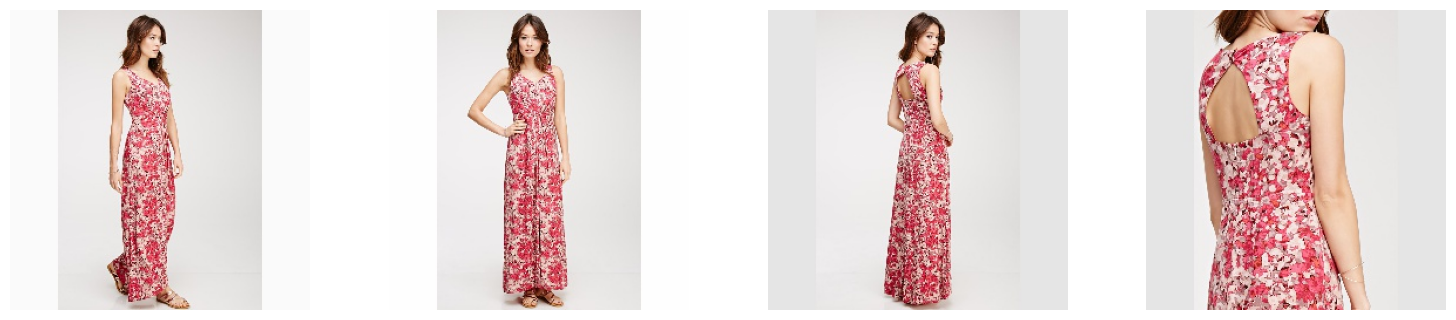

In [ ]:
plot_image_strip(eval_data[eval_data['item_id_y']=='id_00000034']['image_path'].tolist(), figsize=(15, 3), imsize=None, titles=None, gap=0.01)

evaluate result

In [ ]:
eval_data = eval_data.rename(columns={'evaluation_status_y': 'evaluation_status','item_id_y':'item_id'})
eval_data.head()

,image_path,resnet50_embedding,resnet18_embedding,mobilenetv3_embedding,efficientnet_embedding,vit_embedding,clip_embedding,item_id_x,evaluation_status_x,item_id,evaluation_status
8,img/WOMEN/Dresses/id_00000034/02_7_additional.jpg,"[0.20865014, 0.104198754, 1.0722615, 0.1618616...","[0.19691327, 0.035254266, 0.056668926, 0.43486...","[1.7214283, 2.0620646, -0.0, 0.31803465, -0.10...","[-0.07741607, -0.10621711, -0.068624474, -0.06...","[1.008829, 2.9435632, -4.915655, -2.037647, -0...","[0.31213593, -0.27135885, -0.061429337, 0.1599...",id_00000034,query,id_00000034,query
9,img/WOMEN/Dresses/id_00000034/02_2_side.jpg,"[0.18186668, 0.041762892, 0.9944252, 0.0560725...","[0.5049372, 0.024035575, 0.07796989, 0.4763857...","[1.76088, 3.2270238, -0.0, 0.5604613, -0.0, 3....","[0.38678506, -0.13712718, -0.09038045, -0.1030...","[-0.8317444, 1.0299318, -3.8856597, -5.263106,...","[0.23053913, -0.22182783, -0.12552673, 0.32261...",id_00000034,gallery,id_00000034,gallery
10,img/WOMEN/Dresses/id_00000034/02_1_front.jpg,"[0.18670726, 0.08914402, 0.9857989, 0.05581499...","[0.7741344, 0.035473533, 0.06913843, 0.5407373...","[1.9775056, 1.1785682, -0.0, -0.25120392, -0.0...","[0.016733272, -0.06992541, -0.064926796, -0.04...","[2.6303675, -1.263836, -4.646766, -7.463131, 5...","[0.19224523, -0.21367985, -0.059783265, 0.3660...",id_00000034,gallery,id_00000034,gallery
11,img/WOMEN/Dresses/id_00000034/02_3_back.jpg,"[0.35783842, 0.11794777, 1.3012425, 0.11251914...","[0.1849521, 0.11117404, 0.8364727, 1.2676073, ...","[0.37052357, 1.7607778, -0.0, 0.38714504, -0.3...","[0.4730229, -0.13141258, -0.058118273, -0.0883...","[-2.0392685, 4.8527813, -0.35493946, -2.661673...","[0.07275763, -0.2765844, 0.00962171, 0.1754582...",id_00000034,query,id_00000034,query
24,img/WOMEN/Dresses/id_00000386/02_7_additional.jpg,"[0.101423696, 0.071461014, 1.0478377, 0.400191...","[0.23090604, 0.99476993, 0.008749804, 0.870628...","[0.1207506, -0.1431473, -0.0, 0.40994644, -0.3...","[1.4891387, -0.11246209, -0.117383465, -0.0721...","[-0.041475177, 10.306276, -1.1905549, 4.107750...","[-0.23357962, -0.45868355, 0.09664534, 0.41759...",id_00000386,query,id_00000386,query


In [11]:
import pandas as pd
import numpy as np
from sentence_transformers.util import semantic_search
import torch
from typing import List, Dict
from tqdm import tqdm

class RetrievalEvaluator:
    def __init__(self, df: pd.DataFrame, model_cols: List[str]):
        """
        Initialize evaluator with DataFrame containing embeddings

        Args:
            df: DataFrame with embeddings, item_ids, and evaluation status
            model_cols: List of column names containing embeddings
        """
        self.df = df
        self.model_cols = model_cols
        self.query_df = df[df['evaluation_status'] == 'query']
        self.gallery_df = df[df['evaluation_status'] == 'gallery']

    def convert_to_tensor(self, embeddings: List[np.ndarray]) -> torch.Tensor:
        """Convert list of numpy arrays to torch tensor"""
        return torch.tensor(np.stack(embeddings))

    def evaluate_model(self, model_col: str, k_values: List[int] = [1, 2, 3]) -> Dict:
        """
        Evaluate retrieval performance for a single model

        Args:
            model_col: Column name containing embeddings
            k_values: List of k values for recall@k

        Returns:
            Dictionary containing evaluation metrics
        """
        # Convert embeddings to tensors
        query_embeddings = self.convert_to_tensor(self.query_df[model_col].values)
        gallery_embeddings = self.convert_to_tensor(self.gallery_df[model_col].values)

        # Perform semantic search
        hits = semantic_search(
            query_embeddings,
            gallery_embeddings,
            top_k=max(k_values)
        )

        # Calculate metrics for each k
        metrics = {}
        for k in k_values:
            correct = 0
            total = 0

            for i, hit in enumerate(hits):
                query_id = self.query_df.iloc[i]['item_id']
                retrieved_ids = [
                    self.gallery_df.iloc[h['corpus_id']]['item_id']
                    for h in hit[:k]
                ]

                # Check if correct item_id is in top-k results
                if query_id in retrieved_ids:
                    correct += 1
                total += 1

            recall = correct / total if total > 0 else 0
            metrics[f'recall@{k}'] = recall

        return metrics

    def evaluate_all_models(self, k_values: List[int] = [1, 2, 3]) -> pd.DataFrame:
        """
        Evaluate all models and return results as DataFrame
        """
        results = []

        for model_col in tqdm(self.model_cols, desc="Evaluating models"):
            metrics = self.evaluate_model(model_col, k_values)
            metrics['model'] = model_col
            results.append(metrics)

        return pd.DataFrame(results)

    def get_example_retrievals(
        self,
        model_col: str,
        num_examples: int = 5,
        k: int = 3
    ) -> List[Dict]:
        """
        Get example retrievals for qualitative analysis
        """
        query_embeddings = self.convert_to_tensor(self.query_df[model_col].values)
        gallery_embeddings = self.convert_to_tensor(self.gallery_df[model_col].values)

        # Get random sample of queries
        sample_indices = np.random.choice(
            len(self.query_df),
            min(num_examples, len(self.query_df)),
            replace=False
        )

        examples = []
        for idx in sample_indices:
            query_embedding = query_embeddings[idx].unsqueeze(0)
            hits = semantic_search(query_embedding, gallery_embeddings, top_k=k)[0]

            example = {
                'query_image': self.query_df.iloc[idx]['image_path'],
                'query_id': self.query_df.iloc[idx]['item_id'],
                'retrieved': [
                    {
                        'image_path': self.gallery_df.iloc[h['corpus_id']]['image_path'],
                        'item_id': self.gallery_df.iloc[h['corpus_id']]['item_id'],
                        'score': h['score']
                    }
                    for h in hits
                ]
            }
            examples.append(example)

        return examples

# def load_and_prepare_data(filepath: str) -> pd.DataFrame:
#     """
#     Load and prepare data from file
#     """
#     # Read the data
#     df = pd.read_csv(filepath, sep=' ', header=None)

#     # Assign column names
#     df.columns = [
#         'image_path', 'resnet_embedding', 'mobilenet_embedding',
#         'efficientnet_embedding', 'vit_embedding', 'clip_embedding',
#         'item_id', 'evaluation_status', 'id_check', 'eval_status_check'
#     ]

#     # Convert string embeddings to numpy arrays
#     embedding_cols = [
#         'resnet_embedding', 'mobilenet_embedding', 'efficientnet_embedding',
#         'vit_embedding', 'clip_embedding'
#     ]

#     for col in embedding_cols:
#         df[col] = df[col].apply(
#             lambda x: np.array(eval(x.replace('...', '')))
#         )

#     return df

# Example usage
def example_usage():
    # Load data
    df = eval_data
    # Initialize evaluator
    model_cols = [
        'resnet50_embedding', 'resnet18_embedding',
       'mobilenetv3_embedding', 'efficientnet_embedding', 'vit_embedding',
       'clip_embedding'
    ]
    evaluator = RetrievalEvaluator(df, model_cols)

    # Evaluate all models
    results = evaluator.evaluate_all_models(k_values=[1, 2, 3, 5, 10])
    print("\nModel Performance:")
    print(results)

    # # Get example retrievals
    # examples = evaluator.get_example_retrievals('clip_embedding', num_examples=3)

    # print("\nExample Retrievals:")
    # for ex in examples:
    #     print(f"\nQuery: {ex['query_image']} (ID: {ex['query_id']})")
    #     print("Retrieved:")
    #     for ret in ex['retrieved']:
    #         print(f"- {ret['image_path']} (ID: {ret['item_id']}, Score: {ret['score']:.3f})")

    # return results, examples

# if __name__ == "__main__":
#     results, examples = example_usage()

In [ ]:
eval_data.to_parquet('embeddings/all_embeddings_evalstatus_subset.parquet')

In [ ]:
example_usage()

Evaluating models: 100%|██████████| 6/6 [02:25<00:00, 24.24s/it]


Model Performance:
   recall@1  recall@2  recall@3  recall@5  recall@10                   model
0  0.258335  0.324378  0.363131  0.414545   0.485019      resnet50_embedding
1  0.246589  0.309608  0.349768  0.400971   0.468350      resnet18_embedding
2  0.319595  0.392179  0.436208  0.489309   0.555493   mobilenetv3_embedding
3  0.347025  0.423266  0.468280  0.521030   0.591715  efficientnet_embedding
4  0.329020  0.413349  0.459769  0.520467   0.594528           vit_embedding
5  0.454354  0.555141  0.611900  0.672387   0.743002          clip_embedding


In [ ]:
eval_data.columns

Index(['image_path', 'resnet50_embedding', 'resnet18_embedding',
       'mobilenetv3_embedding', 'efficientnet_embedding', 'vit_embedding',
       'clip_embedding', 'item_id_x', 'evaluation_status_x', 'item_id',
       'evaluation_status'],
      dtype='object')

# unicom model 23

UNIVERSAL AND COMPACT
REPRESENTATION LEARNING FOR IMAGE RETRIEVAL

https://arxiv.org/pdf/2304.05884v1

https://github.com/deepglint/unicom/tree/main/unicom

In [12]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, trunc_normal_
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import (CenterCrop, Compose, InterpolationMode,
                                    Normalize, Resize, ToTensor)
import torch.nn.functional as F


class VisionTransformer(nn.Module):
    def __init__(self, input_size=224, patch_size=32, in_channels=3, dim=768, embedding_size=768,
                 depth=12, num_heads=12, mlp_ratio=4, drop_path_rate=0.0, using_checkpoint=True):
        super().__init__()
        self.dim = dim
        self.patch_embed = PatchEmbedding(
            input_size, patch_size, in_channels, dim,)
        self.pos_embed = nn.Parameter(torch.zeros(
            1, self.patch_embed.num_patches, dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]

        self.blocks = nn.ModuleList(
            [
                Block(dim, num_heads, mlp_ratio, dpr[i], self.patch_embed.num_patches, using_checkpoint) for i in range(depth)
            ])
        self.norm = nn.LayerNorm(dim)

        self.feature = nn.Sequential(
            nn.Linear(dim * self.patch_embed.num_patches, dim, False),
            nn.BatchNorm1d(dim, eps=2e-5),
            nn.Linear(dim, embedding_size, False),
            nn.BatchNorm1d(embedding_size, eps=2e-5))

        trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)
        self.extra_gflops = 0.0
        for _block in self.blocks:
            self.extra_gflops += _block.extra_gflops

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        for func in self.blocks:
            x = func(x)
        x = self.norm(x.float())
        return torch.reshape(x, (B, self.patch_embed.num_patches * self.dim))

    def forward(self, x):
        x = self.forward_features(x)
        x = self.feature(x)
        return x


class Mlp(nn.Module):
    def __init__(self, dim, dim_hidden):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim_hidden)
        self.act = nn.ReLU6()
        self.fc2 = nn.Linear(dim_hidden, dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        with torch.cuda.amp.autocast(True):
            B, L, D = x.shape
            qkv = self.qkv(x).reshape(B, L, 3, self.num_heads,
                                      D // self.num_heads).permute(2, 0, 3, 1, 4)
            # B, L, 3, heads, head_dim ->
            # 3, B, heads, L, head_dim
            q, k, v = qkv[0], qkv[1], qkv[2]
            # q B, heads, L, head_dim

            # q (batch_size, num_heads, seq_length, head_dim)
            # k (batch_size, num_heads, seq_length, head_dim)
            # v (batch_size, num_heads, seq_length, head_dim)
            attn_output = F.scaled_dot_product_attention(q, k, v, None, dropout_p=0.0)
            attn_output = attn_output.permute(2, 0, 1, 3).contiguous()  # [seq_length, batch_size, num_heads, head_dim]
            attn_output = attn_output.view(L, B, -1)  # [seq_length, batch_size, embedding_dim]
            attn_output = attn_output.permute(1, 0, 2)  # [batch_size, seq_length, embedding_dim]
            x = self.proj(attn_output)

        # with torch.cuda.amp.autocast(False):
        #     q, k, v = qkv[0].float(), qkv[1].float(), qkv[2].float()
        #     attn = (q @ k.transpose(-2, -1)) * self.scale
        #     attn = attn.softmax(dim=-1)
        #     x = (attn @ v).transpose(1, 2).reshape(B, L, D)
        # with torch.cuda.amp.autocast(True):
        #     x = self.proj(x)

        return x


class Block(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: int = 4, drop_path: float = 0.0, patch_n: int = 32, using_checkpoint=False):
        super().__init__()
        self.using_checkpoint = using_checkpoint
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads)
        if drop_path > 0:
            self.drop_path = DropPath(drop_path)
        else:
            self.drop_path = nn.Identity()
        self.mlp = Mlp(dim, dim * mlp_ratio)
        self.extra_gflops = (num_heads * patch_n * (dim // num_heads) * patch_n * 2) / (1000**3)

    def forward_impl(self, x):
        with torch.cuda.amp.autocast(True):
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

    def forward(self, x):
        # if self.using_checkpoint:
        #     return checkpoint(self.forward_impl, x)
        # else:
        #     return self.forward_impl(x)
        return self.forward_impl(x)


class PatchEmbedding(nn.Module):
    def __init__(self, input_size=224, patch_size=32, in_channels: int = 3, dim: int = 768):
        super().__init__()
        if isinstance(input_size, int):
            input_size = (input_size, input_size)
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        H = input_size[0] // patch_size[0]
        W = input_size[1] // patch_size[1]
        self.num_patches = H * W
        self.proj = nn.Conv2d(
            in_channels, dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


def build_model(name="ViT-L/14@336px"):
    if name == "ViT-B/32":
        model = VisionTransformer(
            input_size=224, patch_size=32, in_channels=3, dim=768, embedding_size=512,
            depth=12, num_heads=12, drop_path_rate=0.1, using_checkpoint=False)
    elif name == "ViT-B/16":
        model = VisionTransformer(
            input_size=224, patch_size=16, in_channels=3, dim=768, embedding_size=768,
            depth=12, num_heads=12, drop_path_rate=0.1, using_checkpoint=False)
    elif name == "ViT-L/14":
        model = VisionTransformer(
            input_size=224, patch_size=14, in_channels=3, dim=1024, embedding_size=768,
            depth=24, num_heads=16, drop_path_rate=0.1, using_checkpoint=False)
    elif name == "ViT-L/14@336px":
        model = VisionTransformer(
            input_size=336, patch_size=14, in_channels=3, dim=1024, embedding_size=768,
            depth=24, num_heads=16, drop_path_rate=0.1, using_checkpoint=False)
    return model


def _convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=InterpolationMode.BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073),
                  (0.26862954, 0.26130258, 0.27577711)),
    ])


def load_model_and_transform(name="ViT-L/14@336px"):
    if name == "ViT-B/32":
        return build_model(name), _transform(224)
    elif name == "ViT-B/16":
        return build_model(name), _transform(224)
    elif name == "ViT-L/14":
        return build_model(name), _transform(224)
    elif name == "ViT-L/14@336px":
        return build_model(name), _transform(336)
    else:
        raise


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [13]:
import hashlib
import os
import urllib
import warnings

import torch
from typing import List
from tqdm import tqdm
# from .vision_transformer import load_model_and_transform


__all__ = ["load", "available_models"]

_MODELS = {
    "ViT-B/32": "https://github.com/deepglint/unicom/releases/download/b32/FP16-ViT-B-32.pt",
    "ViT-B/16": "https://github.com/deepglint/unicom/releases/download/b16/FP16-ViT-B-16.pt",
    "ViT-L/14": "https://github.com/deepglint/unicom/releases/download/l14/FP16-ViT-L-14.pt",
    "ViT-L/14@336px": "https://github.com/deepglint/unicom/releases/download/l14_336px/FP16-ViT-L-14-336px.pt",
}

_SHA256 = {
    "FP16-ViT-B-32.pt": "f9d5696a9b58dbbbefee2d31615ca59084f2895a0fdd2ca4c235e0f9b2793f7a",
    "FP16-ViT-B-16.pt": "c04f324f7c3b4435667236ec6c0eca1cd62f9d64fbfc2d06f8e8e60e6497edef",
    "FP16-ViT-L-14.pt": "ff3ab62ff782876460099e6e0ee17b73a7c01109de2fffd595f16f4129404bbd",
    "FP16-ViT-L-14-336px.pt": "3916ab5aed3b522fc90345be8b4457fe5dad60801ad2af5a6871c0c096e8d7ea",
}


def available_models() -> List[str]:
    """Returns the names of available CLIP models"""
    return list(_MODELS.keys())


def rm_module_from_state_dict(state_dict: dict) -> dict:
    result = {}
    for k, value in state_dict.items():

        if "module." in k:
            k_removed = k.split("module.")[-1]
            result[k_removed] = value
        else:
            result[k] = value
    return result


# copy from https://github.com/openai/CLIP/blob/main/clip/clip.py#L43
def _download(url: str, root: str):
    os.makedirs(root, exist_ok=True)
    filename = os.path.basename(url)

    expected_sha256 = _SHA256[filename]
    download_target = os.path.join(root, filename)

    if os.path.exists(download_target) and not os.path.isfile(download_target):
        raise RuntimeError(
            f"{download_target} exists and is not a regular file")

    if os.path.isfile(download_target):
        if hashlib.sha256(open(download_target, "rb").read()).hexdigest() == expected_sha256:
            return download_target
        else:
            warnings.warn(
                f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")

    with urllib.request.urlopen(url) as source, open(download_target, "wb") as output:
        with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))

    if hashlib.sha256(open(download_target, "rb").read()).hexdigest() != expected_sha256:
        raise RuntimeError(
            "Model has been downloaded but the SHA256 checksum does not not match")

    return download_target


# copy from https://github.com/openai/CLIP/blob/main/clip/clip.py#L94
def load(name: str, device: str = "cpu", download_root: str = None):
    if name in _MODELS:
        model_path = _download(
            _MODELS[name], download_root or os.path.expanduser("~/.cache/unicom"))
    elif os.path.isfile(name):
        model_path = name
    else:
        raise RuntimeError(
            f"Model {name} not found; available models = {available_models()}")
    with open(model_path, 'rb') as opened_file:
        state_dict = torch.load(opened_file, map_location="cpu")

    model, transform = load_model_and_transform(name)
    state_dict_fp32 = {}
    for k, v in state_dict.items():
        state_dict_fp32[k] = v.float()

    model.load_state_dict(state_dict)
    return model, transform


In [18]:
model,transform = load('ViT-L/14@336px')

In [ ]:
import pandas as pd
eval_data = pd.read_parquet('embeddings/all_embeddings_evalstatus_subset.parquet')
eval_data.head()

,image_path,resnet50_embedding,resnet18_embedding,mobilenetv3_embedding,efficientnet_embedding,vit_embedding,clip_embedding,item_id_x,evaluation_status_x,item_id,evaluation_status
8,img/WOMEN/Dresses/id_00000034/02_7_additional.jpg,"[0.20865014, 0.104198754, 1.0722615, 0.1618616...","[0.19691327, 0.035254266, 0.056668926, 0.43486...","[1.7214283, 2.0620646, -0.0, 0.31803465, -0.10...","[-0.07741607, -0.10621711, -0.068624474, -0.06...","[1.008829, 2.9435632, -4.915655, -2.037647, -0...","[0.31213593, -0.27135885, -0.061429337, 0.1599...",id_00000034,query,id_00000034,query
9,img/WOMEN/Dresses/id_00000034/02_2_side.jpg,"[0.18186668, 0.041762892, 0.9944252, 0.0560725...","[0.5049372, 0.024035575, 0.07796989, 0.4763857...","[1.76088, 3.2270238, -0.0, 0.5604613, -0.0, 3....","[0.38678506, -0.13712718, -0.09038045, -0.1030...","[-0.8317444, 1.0299318, -3.8856597, -5.263106,...","[0.23053913, -0.22182783, -0.12552673, 0.32261...",id_00000034,gallery,id_00000034,gallery
10,img/WOMEN/Dresses/id_00000034/02_1_front.jpg,"[0.18670726, 0.08914402, 0.9857989, 0.05581499...","[0.7741344, 0.035473533, 0.06913843, 0.5407373...","[1.9775056, 1.1785682, -0.0, -0.25120392, -0.0...","[0.016733272, -0.06992541, -0.064926796, -0.04...","[2.6303675, -1.263836, -4.646766, -7.463131, 5...","[0.19224523, -0.21367985, -0.059783265, 0.3660...",id_00000034,gallery,id_00000034,gallery
11,img/WOMEN/Dresses/id_00000034/02_3_back.jpg,"[0.35783842, 0.11794777, 1.3012425, 0.11251914...","[0.1849521, 0.11117404, 0.8364727, 1.2676073, ...","[0.37052357, 1.7607778, -0.0, 0.38714504, -0.3...","[0.4730229, -0.13141258, -0.058118273, -0.0883...","[-2.0392685, 4.8527813, -0.35493946, -2.661673...","[0.07275763, -0.2765844, 0.00962171, 0.1754582...",id_00000034,query,id_00000034,query
24,img/WOMEN/Dresses/id_00000386/02_7_additional.jpg,"[0.101423696, 0.071461014, 1.0478377, 0.400191...","[0.23090604, 0.99476993, 0.008749804, 0.870628...","[0.1207506, -0.1431473, -0.0, 0.40994644, -0.3...","[1.4891387, -0.11246209, -0.117383465, -0.0721...","[-0.041475177, 10.306276, -1.1905549, 4.107750...","[-0.23357962, -0.45868355, 0.09664534, 0.41759...",id_00000386,query,id_00000386,query


In [ ]:
eval_data['image_path'].tolist()[0]

'img/WOMEN/Dresses/id_00000034/02_7_additional.jpg'

In [ ]:
import numpy as np
from PIL import Image
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Make sure the model is in evaluation mode
model = model.to(device)
model.eval()  # This is crucial - sets BatchNorm to evaluation mode

# Process the image
image_path = eval_data['image_path'].tolist()[0]
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

# Get embedding using no_grad context
with torch.no_grad():  # Disable gradient computation for inference
    embedding = model(input_tensor)
    embedding = embedding.cpu().numpy()
    # print(embedding)

NameError: name 'eval_data' is not defined

In [ ]:
def extract_embeddings_batch(model, transform, image_paths, batch_size=32, device='cuda'):
    """
    Extract embeddings for multiple images in batches

    Args:
        model: The neural network model
        transform: Image transformation pipeline
        image_paths: List of paths to image files
        batch_size: Number of images to process at once
        device: Device to run inference on

    Returns:
        numpy array: Array of embeddings (n_images x embedding_dim)
    """
    # Ensure model is in eval mode
    model = model.to(device)
    model.eval()

    all_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing batches"):
            batch_paths = image_paths[i:i + batch_size]

            # Load and transform batch of images
            batch_tensors = []
            for path in batch_paths:
                try:
                    image = Image.open(path).convert('RGB')
                    tensor = transform(image)
                    batch_tensors.append(tensor)
                except Exception as e:
                    print(f"Error processing {path}: {str(e)}")
                    # Add zero tensor as placeholder for failed images
                    batch_tensors.append(torch.zeros_like(batch_tensors[0]) if batch_tensors else torch.zeros((3, 224, 224)))

            # Stack batch tensors and move to device
            batch_input = torch.stack(batch_tensors).to(device)

            # Get embeddings for batch
            batch_embeddings = model(batch_input)
            all_embeddings.append(batch_embeddings.cpu().numpy())

    # Concatenate all batches
    final_embeddings = np.vstack(all_embeddings)

    return final_embeddings

# Example usage:
def process_dataset(model, transform, image_paths, batch_size=32):
    """
    Process entire dataset and return embeddings with error handling
    """
    try:
        embeddings = extract_embeddings_batch(
            model=model,
            transform=transform,
            image_paths=image_paths,
            batch_size=batch_size
        )

        print(f"Processed {len(image_paths)} images")
        print(f"Embedding shape: {embeddings.shape}")

        return embeddings

    except Exception as e:
        print(f"Error processing dataset: {str(e)}")
        return None

In [ ]:
# Usage:
image_paths = eval_data['image_path'].tolist()
embeddings = process_dataset(model, transform, image_paths, batch_size=64)

In [ ]:
eval_data['unicom']=embeddings.tolist()
eval_data.head()

,image_path,resnet50_embedding,resnet18_embedding,mobilenetv3_embedding,efficientnet_embedding,vit_embedding,clip_embedding,item_id_x,evaluation_status_x,item_id,evaluation_status,unicom
8,img/WOMEN/Dresses/id_00000034/02_7_additional.jpg,"[0.20865014, 0.104198754, 1.0722615, 0.1618616...","[0.19691327, 0.035254266, 0.056668926, 0.43486...","[1.7214283, 2.0620646, -0.0, 0.31803465, -0.10...","[-0.07741607, -0.10621711, -0.068624474, -0.06...","[1.008829, 2.9435632, -4.915655, -2.037647, -0...","[0.31213593, -0.27135885, -0.061429337, 0.1599...",id_00000034,query,id_00000034,query,"[0.014777871780097485, -0.17241372168064117, 0..."
9,img/WOMEN/Dresses/id_00000034/02_2_side.jpg,"[0.18186668, 0.041762892, 0.9944252, 0.0560725...","[0.5049372, 0.024035575, 0.07796989, 0.4763857...","[1.76088, 3.2270238, -0.0, 0.5604613, -0.0, 3....","[0.38678506, -0.13712718, -0.09038045, -0.1030...","[-0.8317444, 1.0299318, -3.8856597, -5.263106,...","[0.23053913, -0.22182783, -0.12552673, 0.32261...",id_00000034,gallery,id_00000034,gallery,"[0.04245053604245186, -0.173731729388237, 0.10..."
10,img/WOMEN/Dresses/id_00000034/02_1_front.jpg,"[0.18670726, 0.08914402, 0.9857989, 0.05581499...","[0.7741344, 0.035473533, 0.06913843, 0.5407373...","[1.9775056, 1.1785682, -0.0, -0.25120392, -0.0...","[0.016733272, -0.06992541, -0.064926796, -0.04...","[2.6303675, -1.263836, -4.646766, -7.463131, 5...","[0.19224523, -0.21367985, -0.059783265, 0.3660...",id_00000034,gallery,id_00000034,gallery,"[0.07034991681575775, -0.10942920297384262, 0...."
11,img/WOMEN/Dresses/id_00000034/02_3_back.jpg,"[0.35783842, 0.11794777, 1.3012425, 0.11251914...","[0.1849521, 0.11117404, 0.8364727, 1.2676073, ...","[0.37052357, 1.7607778, -0.0, 0.38714504, -0.3...","[0.4730229, -0.13141258, -0.058118273, -0.0883...","[-2.0392685, 4.8527813, -0.35493946, -2.661673...","[0.07275763, -0.2765844, 0.00962171, 0.1754582...",id_00000034,query,id_00000034,query,"[0.012082257308065891, -0.22131825983524323, 0..."
24,img/WOMEN/Dresses/id_00000386/02_7_additional.jpg,"[0.101423696, 0.071461014, 1.0478377, 0.400191...","[0.23090604, 0.99476993, 0.008749804, 0.870628...","[0.1207506, -0.1431473, -0.0, 0.40994644, -0.3...","[1.4891387, -0.11246209, -0.117383465, -0.0721...","[-0.041475177, 10.306276, -1.1905549, 4.107750...","[-0.23357962, -0.45868355, 0.09664534, 0.41759...",id_00000386,query,id_00000386,query,"[0.04499940574169159, -0.16124756634235382, -0..."


In [ ]:
df = eval_data
    # Initialize evaluator
model_cols = [
    'resnet50_embedding', 'resnet18_embedding',
    'mobilenetv3_embedding', 'efficientnet_embedding', 'vit_embedding',
    'clip_embedding','unicom'
]
evaluator = RetrievalEvaluator(df, model_cols)

# Evaluate all models
results = evaluator.evaluate_all_models(k_values=[1, 2, 3, 5, 10])
print("\nModel Performance:")
print(results)

Evaluating models: 100%|██████████| 7/7 [03:02<00:00, 26.11s/it]


Model Performance:
   recall@1  recall@2  recall@3  recall@5  recall@10                   model
0  0.258335  0.324378  0.363131  0.414545   0.485019      resnet50_embedding
1  0.246589  0.309608  0.349768  0.400971   0.468350      resnet18_embedding
2  0.319595  0.392179  0.436208  0.489309   0.555493   mobilenetv3_embedding
3  0.347025  0.423266  0.468280  0.521030   0.591715  efficientnet_embedding
4  0.329020  0.413349  0.459769  0.520467   0.594528           vit_embedding
5  0.454354  0.555141  0.611900  0.672387   0.743002          clip_embedding
6  0.861865  0.909481  0.930089  0.949079   0.967084                  unicom


In [ ]:
eval_data.to_parquet('embeddings/all_embeddings_eval_subset_with_unicom.parquet')

# now lets test embedding creation time for each model

In [ ]:
import glob
import time
from statistics import mean

data = glob.glob('img/**/*.jpg', recursive=True)
print(f"Found {len(data)} images")

extractor = EmbeddingExtractor()

# Load desired models
extractor.load_resnet50()
extractor.load_resnet18()
extractor.load_mobilenetv3()
extractor.load_clip()
extractor.load_efficientnet()
extractor.load_vit()

# Function to measure extraction time
def measure_extraction_time(image_path, model_name, num_runs=5):
    times = []
    for _ in range(num_runs):
        start_time = time.perf_counter()
        _ = extractor.extract_embedding(image_path, model_name)
        end_time = time.perf_counter()
        times.append(end_time - start_time)
    return mean(times)

# Extract embeddings and measure time for single image
image_path = data[0]
print(f"Testing with image: {image_path}")
print("\nAverage extraction times over 5 runs:")

models = ['resnet50', 'resnet18', 'mobilenetv3', 'clip', 'vit', 'efficientnet']
results = {}

for model in models:
    avg_time = measure_extraction_time(image_path, model)
    results[model] = avg_time
    print(f"{model:12} : {avg_time:.4f} seconds")

# Sort and display models by speed
print("\nModels ranked by speed (fastest to slowest):")
sorted_models = sorted(results.items(), key=lambda x: x[1])
for model, time_taken in sorted_models:
    print(f"{model:12} : {time_taken:.4f} seconds")

Found 52712 images
Testing with image: img/MEN/Tees_Tanks/id_00000185/01_1_front.jpg

Average extraction times over 5 runs:
resnet50     : 0.2091 seconds
resnet18     : 0.0922 seconds
mobilenetv3  : 0.0325 seconds
clip         : 0.2223 seconds
vit          : 0.9554 seconds
efficientnet : 0.0582 seconds

Models ranked by speed (fastest to slowest):
mobilenetv3  : 0.0325 seconds
efficientnet : 0.0582 seconds
resnet18     : 0.0922 seconds
resnet50     : 0.2091 seconds
clip         : 0.2223 seconds
vit          : 0.9554 seconds


In [ ]:
import glob
import time
import numpy as np
from PIL import Image
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

image_path = data[0]
print(f"\nTesting with image: {image_path}")

start_time = time.perf_counter()

# Load and preprocess image
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

# Model inference
model.eval()
with torch.no_grad():
    embedding = model(input_tensor)
    embedding = embedding.cpu().numpy()

end_time = time.perf_counter()
print(f"{'unicom-vit':12} : {end_time - start_time:.4f} seconds")

Using device: cpu

Testing with image: img/MEN/Tees_Tanks/id_00000185/01_1_front.jpg


<ipython-input-14-c16a9e546e7b>:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
<ipython-input-14-c16a9e546e7b>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):


unicom-vit   : 8.9080 seconds


## now gpu timings

In [21]:
import glob
import time
from statistics import mean

data = glob.glob('img/**/*.jpg', recursive=True)
print(f"Found {len(data)} images")

extractor = EmbeddingExtractor()

# Load desired models
extractor.load_resnet50()
extractor.load_resnet18()
extractor.load_mobilenetv3()
extractor.load_clip()
extractor.load_efficientnet()
extractor.load_vit()

# Function to measure extraction time
def measure_extraction_time(image_path, model_name, num_runs=5):
    times = []
    for _ in range(num_runs):
        start_time = time.perf_counter()
        _ = extractor.extract_embedding(image_path, model_name)
        end_time = time.perf_counter()
        times.append(end_time - start_time)
    return mean(times)

# Extract embeddings and measure time for single image
image_path = data[0]
print(f"Testing with image: {image_path}")
print("\nAverage extraction times over 5 runs:")

models = ['resnet50', 'resnet18', 'mobilenetv3', 'clip', 'vit', 'efficientnet']
results = {}

for model in models:
    avg_time = measure_extraction_time(image_path, model)
    results[model] = avg_time
    print(f"{model:12} : {avg_time:.4f} seconds")

# Sort and display models by speed
print("\nModels ranked by speed (fastest to slowest):")
sorted_models = sorted(results.items(), key=lambda x: x[1])
for model, time_taken in sorted_models:
    print(f"{model:12} : {time_taken:.4f} seconds")

Found 52712 images
Testing with image: img/WOMEN/Tees_Tanks/id_00007981/03_7_additional.jpg

Average extraction times over 5 runs:
resnet50     : 0.0097 seconds
resnet18     : 0.0111 seconds
mobilenetv3  : 0.0213 seconds
clip         : 0.0128 seconds
vit          : 0.0117 seconds
efficientnet : 0.0288 seconds

Models ranked by speed (fastest to slowest):
resnet50     : 0.0097 seconds
resnet18     : 0.0111 seconds
vit          : 0.0117 seconds
clip         : 0.0128 seconds
mobilenetv3  : 0.0213 seconds
efficientnet : 0.0288 seconds


In [20]:
import glob
import time
import numpy as np
from PIL import Image
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

image_path = data[0]
print(f"\nTesting with image: {image_path}")

start_time = time.perf_counter()

# Load and preprocess image
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

# Model inference
model.eval()
with torch.no_grad():
    embedding = model.to(device)(input_tensor)
    embedding = embedding.cpu().numpy()

end_time = time.perf_counter()
print(f"{'unicom-vit':12} : {end_time - start_time:.4f} seconds")

Using device: cuda

Testing with image: img/WOMEN/Tees_Tanks/id_00007981/03_7_additional.jpg
unicom-vit   : 0.6008 seconds


## lets finetune resnet50 as student and unicom vit as teacher

In [29]:
filepath = 'list_eval_partition.txt'
file = open(filepath, 'r')

lines = file.readlines()

training_data = []
for line in lines:
    parts = line.strip().split()
    image_path = parts[0]
    item_id = parts[1]
    evaluation_status = parts[2]
    training_data.append([image_path, item_id, evaluation_status])

training_df = pd.DataFrame(training_data[1:], columns=['image_path', 'item_id', 'evaluation_status'])

training_df.head()

,image_path,item_id,evaluation_status
0,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,id_00000002,train
1,img/WOMEN/Dresses/id_00000002/02_2_side.jpg,id_00000002,train
2,img/WOMEN/Dresses/id_00000002/02_4_full.jpg,id_00000002,train
3,img/WOMEN/Dresses/id_00000002/02_7_additional.jpg,id_00000002,train
4,img/WOMEN/Skirts/id_00000003/02_1_front.jpg,id_00000003,train


In [30]:
training_path = training_df[training_df['evaluation_status']=='train']['image_path'].tolist()
training_path[:4]

['img/WOMEN/Dresses/id_00000002/02_1_front.jpg',
 'img/WOMEN/Dresses/id_00000002/02_2_side.jpg',
 'img/WOMEN/Dresses/id_00000002/02_4_full.jpg',
 'img/WOMEN/Dresses/id_00000002/02_7_additional.jpg']

In [33]:
import random

def split_train_val(image_paths, val_ratio=0.2, seed=None):
    """
    Splits the given list of image paths into training and validation lists.

    Args:
        image_paths (list): A list of image file paths.
        val_ratio (float): The proportion of the data to include in the validation set.
        seed (int, optional): A random seed for reproducibility.

    Returns:
        tuple: A tuple containing two lists - (train_list, val_list).
    """
    if seed is not None:
        random.seed(seed)
    
    # Shuffle the image paths
    random.shuffle(image_paths)
    
    # Determine the split index
    split_index = int(len(image_paths) * (1 - val_ratio))
    
    # Split the paths into training and validation lists
    train_list = image_paths[:split_index]
    val_list = image_paths[split_index:]
    
    return train_list, val_list

# Example usage
train_list, val_list = split_train_val(training_path, val_ratio=0.2, seed=42)
print("Training List:", train_list[:5])
print("Validation List:", val_list[:5])


Training List: ['img/WOMEN/Tees_Tanks/id_00006242/11_1_front.jpg', 'img/WOMEN/Dresses/id_00001323/01_1_front.jpg', 'img/MEN/Tees_Tanks/id_00003470/11_3_back.jpg', 'img/MEN/Tees_Tanks/id_00007075/01_4_full.jpg', 'img/WOMEN/Shorts/id_00005138/05_1_front.jpg']
Validation List: ['img/WOMEN/Jackets_Coats/id_00001670/02_7_additional.jpg', 'img/WOMEN/Tees_Tanks/id_00007185/02_1_front.jpg', 'img/WOMEN/Dresses/id_00003659/06_4_full.jpg', 'img/WOMEN/Tees_Tanks/id_00006183/02_7_additional.jpg', 'img/WOMEN/Blouses_Shirts/id_00007347/01_7_additional.jpg']


In [ ]:
# val_path = 

In [83]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class StudentModel(nn.Module):
    def __init__(self, embedding_dim=768):
        super(StudentModel, self).__init__()
        # Load pretrained ResNet50 without the final layer
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        
        # Replace BatchNorm with LayerNorm or disable BatchNorm
        self.features.eval()  # Keep BatchNorm in eval mode
        
        # Add embedding layer
        self.embedding_layer = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, embedding_dim)
        )
        
    def forward(self, x):
        # Extract features with frozen BatchNorm
        with torch.no_grad():
            features = self.features(x)
        features = features.view(features.size(0), -1)  # Flatten
        # Get embeddings through trainable layers
        embedding = self.embedding_layer(features)
        return embedding

# Training setup
def train_student(teacher_model, student_model, train_loader, num_epochs=10, device='cuda'):
    # Loss function - MSE for embedding similarity
    criterion = nn.MSELoss()
    # Optimizer
    optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
    
    teacher_model.eval()  # Teacher model in eval mode
    student_model.train()  # Student model in training mode
    
    for epoch in range(num_epochs):
        total_loss = 0
        for images in train_loader:
            images = images.to(device)
            
            # Get teacher embeddings
            with torch.no_grad():
                teacher_embeddings = teacher_model(images)
            
            # Get student embeddings
            student_embeddings = student_model(images)
            
            # Calculate loss
            loss = criterion(student_embeddings, teacher_embeddings)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

In [84]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [85]:
# Usage example:
# def teacher_student_main():
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model,transform = load('ViT-L/14@336px')
# Initialize models
teacher_model = model  # Your existing model
student_model = StudentModel(embedding_dim=768)

# Move models to device
teacher_model = teacher_model.to(device)
student_model = student_model.to(device)


dataset = CustomDataset(train_list, transform=transform)
val_dataset = CustomDataset(val_list, transform=transform)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train_student(teacher_model, student_model, train_loader, val_loader, 
                 num_epochs=50, device='cuda', lr=1e-4):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(student_model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        student_model.train()
        train_loss = 0
        
        for batch_idx, images in enumerate(train_loader):
            images = images.to(device)
            
            # Get teacher embeddings
            with torch.no_grad():
                teacher_embeddings = teacher_model(images)
            
            # Get student embeddings
            student_embeddings = student_model(images)
            
            # Calculate loss
            loss = criterion(student_embeddings, teacher_embeddings)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        student_model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                
                teacher_embeddings = teacher_model(images)
                student_embeddings = student_model(images)
                
                loss = criterion(student_embeddings, teacher_embeddings)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        print(f'Average Val Loss: {avg_val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': student_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss
            }, 'best_student_model.pth')
            print(f'Saved new best model with validation loss: {best_val_loss:.4f}')
        
        print('-' * 60)

train_student(teacher_model, student_model, train_loader, val_loader, 
                 num_epochs=10, device='cuda', lr=1e-4)

Epoch [1/10], Batch [50/324], Loss: 0.0121
Epoch [1/10], Batch [100/324], Loss: 0.0115
Epoch [1/10], Batch [150/324], Loss: 0.0112
Epoch [1/10], Batch [200/324], Loss: 0.0110
Epoch [1/10], Batch [250/324], Loss: 0.0106
Epoch [1/10], Batch [300/324], Loss: 0.0104
Epoch [1/10]
Average Train Loss: 0.0112
Average Val Loss: 0.0104
Learning Rate: 0.000100
Saved new best model with validation loss: 0.0104
------------------------------------------------------------
Epoch [2/10], Batch [50/324], Loss: 0.0102
Epoch [2/10], Batch [100/324], Loss: 0.0099
Epoch [2/10], Batch [150/324], Loss: 0.0100
Epoch [2/10], Batch [200/324], Loss: 0.0099
Epoch [2/10], Batch [250/324], Loss: 0.0101
Epoch [2/10], Batch [300/324], Loss: 0.0098
Epoch [2/10]
Average Train Loss: 0.0100
Average Val Loss: 0.0099
Learning Rate: 0.000100
Saved new best model with validation loss: 0.0099
------------------------------------------------------------
Epoch [3/10], Batch [50/324], Loss: 0.0096
Epoch [3/10], Batch [100/324], 

In [51]:
# device

In [52]:
def load_best_model(student_model, path='best_student_model.pth'):
    checkpoint = torch.load(path)
    student_model.load_state_dict(checkpoint['model_state_dict'])
    return student_model, checkpoint['best_val_loss']

In [54]:
resnet_finetuned,_ = load_best_model(student_model, path='best_student_model.pth')

In [53]:
import pandas as pd
eval_data = pd.read_parquet('all_embeddings_eval_subset_with_unicom.parquet')
eval_data.head()

,image_path,resnet50_embedding,resnet18_embedding,mobilenetv3_embedding,efficientnet_embedding,vit_embedding,clip_embedding,item_id_x,evaluation_status_x,item_id,evaluation_status,unicom
8,img/WOMEN/Dresses/id_00000034/02_7_additional.jpg,"[0.20865014, 0.104198754, 1.0722615, 0.1618616...","[0.19691327, 0.035254266, 0.056668926, 0.43486...","[1.7214283, 2.0620646, -0.0, 0.31803465, -0.10...","[-0.07741607, -0.10621711, -0.068624474, -0.06...","[1.008829, 2.9435632, -4.915655, -2.037647, -0...","[0.31213593, -0.27135885, -0.061429337, 0.1599...",id_00000034,query,id_00000034,query,"[0.014777871780097485, -0.17241372168064117, 0..."
9,img/WOMEN/Dresses/id_00000034/02_2_side.jpg,"[0.18186668, 0.041762892, 0.9944252, 0.0560725...","[0.5049372, 0.024035575, 0.07796989, 0.4763857...","[1.76088, 3.2270238, -0.0, 0.5604613, -0.0, 3....","[0.38678506, -0.13712718, -0.09038045, -0.1030...","[-0.8317444, 1.0299318, -3.8856597, -5.263106,...","[0.23053913, -0.22182783, -0.12552673, 0.32261...",id_00000034,gallery,id_00000034,gallery,"[0.04245053604245186, -0.173731729388237, 0.10..."
10,img/WOMEN/Dresses/id_00000034/02_1_front.jpg,"[0.18670726, 0.08914402, 0.9857989, 0.05581499...","[0.7741344, 0.035473533, 0.06913843, 0.5407373...","[1.9775056, 1.1785682, -0.0, -0.25120392, -0.0...","[0.016733272, -0.06992541, -0.064926796, -0.04...","[2.6303675, -1.263836, -4.646766, -7.463131, 5...","[0.19224523, -0.21367985, -0.059783265, 0.3660...",id_00000034,gallery,id_00000034,gallery,"[0.07034991681575775, -0.10942920297384262, 0...."
11,img/WOMEN/Dresses/id_00000034/02_3_back.jpg,"[0.35783842, 0.11794777, 1.3012425, 0.11251914...","[0.1849521, 0.11117404, 0.8364727, 1.2676073, ...","[0.37052357, 1.7607778, -0.0, 0.38714504, -0.3...","[0.4730229, -0.13141258, -0.058118273, -0.0883...","[-2.0392685, 4.8527813, -0.35493946, -2.661673...","[0.07275763, -0.2765844, 0.00962171, 0.1754582...",id_00000034,query,id_00000034,query,"[0.012082257308065891, -0.22131825983524323, 0..."
24,img/WOMEN/Dresses/id_00000386/02_7_additional.jpg,"[0.101423696, 0.071461014, 1.0478377, 0.400191...","[0.23090604, 0.99476993, 0.008749804, 0.870628...","[0.1207506, -0.1431473, -0.0, 0.40994644, -0.3...","[1.4891387, -0.11246209, -0.117383465, -0.0721...","[-0.041475177, 10.306276, -1.1905549, 4.107750...","[-0.23357962, -0.45868355, 0.09664534, 0.41759...",id_00000386,query,id_00000386,query,"[0.04499940574169159, -0.16124756634235382, -0..."


In [55]:
image_paths = eval_data['image_path'].tolist()
embeddings = process_dataset(resnet_finetuned, transform, image_paths, batch_size=64)

Processing batches: 100%|██████████| 420/420 [08:41<00:00,  1.24s/it]

Processed 26830 images
Embedding shape: (26830, 768)


In [56]:
eval_data['resnet50_finetuned']=embeddings.tolist()
eval_data.head()

,image_path,resnet50_embedding,resnet18_embedding,mobilenetv3_embedding,efficientnet_embedding,vit_embedding,clip_embedding,item_id_x,evaluation_status_x,item_id,evaluation_status,unicom,resnet50_finetuned
8,img/WOMEN/Dresses/id_00000034/02_7_additional.jpg,"[0.20865014, 0.104198754, 1.0722615, 0.1618616...","[0.19691327, 0.035254266, 0.056668926, 0.43486...","[1.7214283, 2.0620646, -0.0, 0.31803465, -0.10...","[-0.07741607, -0.10621711, -0.068624474, -0.06...","[1.008829, 2.9435632, -4.915655, -2.037647, -0...","[0.31213593, -0.27135885, -0.061429337, 0.1599...",id_00000034,query,id_00000034,query,"[0.014777871780097485, -0.17241372168064117, 0...","[0.01065197866410017, -0.05062161386013031, 0...."
9,img/WOMEN/Dresses/id_00000034/02_2_side.jpg,"[0.18186668, 0.041762892, 0.9944252, 0.0560725...","[0.5049372, 0.024035575, 0.07796989, 0.4763857...","[1.76088, 3.2270238, -0.0, 0.5604613, -0.0, 3....","[0.38678506, -0.13712718, -0.09038045, -0.1030...","[-0.8317444, 1.0299318, -3.8856597, -5.263106,...","[0.23053913, -0.22182783, -0.12552673, 0.32261...",id_00000034,gallery,id_00000034,gallery,"[0.04245053604245186, -0.173731729388237, 0.10...","[0.008118245750665665, -0.10284291952848434, 0..."
10,img/WOMEN/Dresses/id_00000034/02_1_front.jpg,"[0.18670726, 0.08914402, 0.9857989, 0.05581499...","[0.7741344, 0.035473533, 0.06913843, 0.5407373...","[1.9775056, 1.1785682, -0.0, -0.25120392, -0.0...","[0.016733272, -0.06992541, -0.064926796, -0.04...","[2.6303675, -1.263836, -4.646766, -7.463131, 5...","[0.19224523, -0.21367985, -0.059783265, 0.3660...",id_00000034,gallery,id_00000034,gallery,"[0.07034991681575775, -0.10942920297384262, 0....","[0.06013975292444229, -0.12955637276172638, 0...."
11,img/WOMEN/Dresses/id_00000034/02_3_back.jpg,"[0.35783842, 0.11794777, 1.3012425, 0.11251914...","[0.1849521, 0.11117404, 0.8364727, 1.2676073, ...","[0.37052357, 1.7607778, -0.0, 0.38714504, -0.3...","[0.4730229, -0.13141258, -0.058118273, -0.0883...","[-2.0392685, 4.8527813, -0.35493946, -2.661673...","[0.07275763, -0.2765844, 0.00962171, 0.1754582...",id_00000034,query,id_00000034,query,"[0.012082257308065891, -0.22131825983524323, 0...","[-0.021420713514089584, 0.01723611168563366, 0..."
24,img/WOMEN/Dresses/id_00000386/02_7_additional.jpg,"[0.101423696, 0.071461014, 1.0478377, 0.400191...","[0.23090604, 0.99476993, 0.008749804, 0.870628...","[0.1207506, -0.1431473, -0.0, 0.40994644, -0.3...","[1.4891387, -0.11246209, -0.117383465, -0.0721...","[-0.041475177, 10.306276, -1.1905549, 4.107750...","[-0.23357962, -0.45868355, 0.09664534, 0.41759...",id_00000386,query,id_00000386,query,"[0.04499940574169159, -0.16124756634235382, -0...","[0.07730229943990707, -0.08911792933940887, 0...."


In [57]:
df = eval_data
    # Initialize evaluator
model_cols = [
    'resnet50_embedding', 'resnet18_embedding',
    'mobilenetv3_embedding', 'efficientnet_embedding', 'vit_embedding',
    'clip_embedding','unicom','resnet50_finetuned'
]
evaluator = RetrievalEvaluator(df, model_cols)

# Evaluate all models
results = evaluator.evaluate_all_models(k_values=[1, 2, 3, 5, 10])
print("\nModel Performance:")
print(results)

Evaluating models: 100%|██████████| 8/8 [02:23<00:00, 17.96s/it]


Model Performance:
   recall@1  recall@2  recall@3  recall@5  recall@10                   model
0  0.258335  0.324378  0.363131  0.414545   0.485019      resnet50_embedding
1  0.246589  0.309608  0.349768  0.400971   0.468350      resnet18_embedding
2  0.319595  0.392179  0.436208  0.489309   0.555493   mobilenetv3_embedding
3  0.347025  0.423266  0.468280  0.521030   0.591715  efficientnet_embedding
4  0.329020  0.413349  0.459769  0.520467   0.594528           vit_embedding
5  0.454354  0.555141  0.611971  0.672457   0.743002          clip_embedding
6  0.861865  0.909481  0.930089  0.949079   0.967084                  unicom
7  0.358982  0.461176  0.519342  0.593192   0.685188      resnet50_finetuned


## now train projection layer in clip as student

In [60]:
class CLIPStudentModel(nn.Module):
    def __init__(self, embedding_dim=768):
        super(CLIPStudentModel, self).__init__()
        # Load CLIP model
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
        # CLIP ViT-base outputs 512 dimensions
        self.embedding_layer = nn.Sequential(
            nn.Linear(512, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
        
    def forward(self, x):
        # Remove the extra dimension if present
        if x.dim() == 5:  # [batch, 1, channels, height, width]
            x = x.squeeze(1)
        # Get CLIP image features
        with torch.no_grad():
            clip_features = self.clip.get_image_features(x)
        # Project to target embedding dimension
        embedding = self.embedding_layer(clip_features)
        return embedding

class DualTransformDataset(Dataset):
    def __init__(self, image_paths, teacher_transform, student_processor):
        self.image_paths = image_paths
        self.teacher_transform = teacher_transform
        self.student_processor = student_processor
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        # Apply both transforms
        teacher_img = self.teacher_transform(image)
        student_img = self.student_processor(images=image, return_tensors="pt").pixel_values
        
        return teacher_img, student_img

# Set teacher model to eval mode at the start
teacher_model.eval()  # Add this line before training

def train_clip_student(teacher_model, student_model, train_loader, val_loader, 
                      num_epochs=10, device='cuda', lr=1e-4):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(student_model.embedding_layer.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    
    best_val_loss = float('inf')
    
    # Keep teacher model in eval mode
    teacher_model.eval()  
    
    for epoch in range(num_epochs):
        # Training phase - only student model trains
        student_model.train()
        train_loss = 0
        
        for batch_idx, (teacher_imgs, student_imgs) in enumerate(train_loader):
            teacher_imgs = teacher_imgs.to(device)
            student_imgs = student_imgs.to(device)
            
            # Get teacher embeddings
            with torch.no_grad():
                teacher_embeddings = teacher_model(teacher_imgs)
            
            # Get student embeddings
            student_embeddings = student_model(student_imgs)
            
            # Calculate loss
            loss = criterion(student_embeddings, teacher_embeddings)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        student_model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for teacher_imgs, student_imgs in val_loader:
                teacher_imgs = teacher_imgs.to(device)
                student_imgs = student_imgs.to(device)
                
                teacher_embeddings = teacher_model(teacher_imgs)
                student_embeddings = student_model(student_imgs)
                
                loss = criterion(student_embeddings, teacher_embeddings)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        print(f'Average Val Loss: {avg_val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': student_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss
            }, 'best_clip_student_model.pth')
            print(f'Saved new best model with validation loss: {best_val_loss:.4f}')
        
        print('-' * 60)

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')





# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
student_model = CLIPStudentModel(embedding_dim=768)
student_processor = student_model.processor

# Create datasets with dual transforms
train_dataset = DualTransformDataset(train_list, teacher_transform=transform, 
                                   student_processor=student_processor)
val_dataset = DualTransformDataset(val_list, teacher_transform=transform, 
                                 student_processor=student_processor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Move models to device
# Initialize models and set teacher to eval mode
teacher_model = teacher_model.to(device)
teacher_model.eval()  # Important: Set teacher model to eval mode
student_model = student_model.to(device)

# Train the student
train_clip_student(
    teacher_model=teacher_model,
    student_model=student_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    device=device,
    lr=1e-4
)



Epoch [1/10], Batch [10/324], Loss: 0.0155
Epoch [1/10], Batch [20/324], Loss: 0.0139
Epoch [1/10], Batch [30/324], Loss: 0.0138
Epoch [1/10], Batch [40/324], Loss: 0.0128
Epoch [1/10], Batch [50/324], Loss: 0.0130
Epoch [1/10], Batch [60/324], Loss: 0.0126
Epoch [1/10], Batch [70/324], Loss: 0.0123
Epoch [1/10], Batch [80/324], Loss: 0.0123
Epoch [1/10], Batch [90/324], Loss: 0.0126
Epoch [1/10], Batch [100/324], Loss: 0.0114
Epoch [1/10], Batch [110/324], Loss: 0.0118
Epoch [1/10], Batch [120/324], Loss: 0.0112
Epoch [1/10], Batch [130/324], Loss: 0.0113
Epoch [1/10], Batch [140/324], Loss: 0.0111
Epoch [1/10], Batch [150/324], Loss: 0.0114
Epoch [1/10], Batch [160/324], Loss: 0.0110
Epoch [1/10], Batch [170/324], Loss: 0.0104
Epoch [1/10], Batch [180/324], Loss: 0.0102
Epoch [1/10], Batch [190/324], Loss: 0.0113
Epoch [1/10], Batch [200/324], Loss: 0.0107
Epoch [1/10], Batch [210/324], Loss: 0.0108
Epoch [1/10], Batch [220/324], Loss: 0.0102
Epoch [1/10], Batch [230/324], Loss: 0.00

In [63]:
clip_finetuned,_ = load_best_model(student_model, path='best_clip_student_model.pth')

In [65]:
image_path = image_paths[0]
image = Image.open(image_path).convert('RGB')


clip_finetuned_img = clip_finetuned_processor(images=image, return_tensors="pt").pixel_values
clip_finetuned_img.shape    

torch.Size([1, 3, 224, 224])

In [66]:
image_paths = eval_data['image_path'].tolist()
clip_finetuned = clip_finetuned.to(device)
clip_finetuned_processor = clip_finetuned.processor
clip_finetuned.eval()

all_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(image_paths), 64), desc="Processing batches"):
        batch_paths = image_paths[i:i + 64]

        # Load and transform batch of images
        batch_tensors = []
        for path in batch_paths:
            try:
                image = Image.open(path).convert('RGB')
                tensor = clip_finetuned_processor(images=image, return_tensors="pt").pixel_values
                batch_tensors.append(tensor)
            except Exception as e:
                print(f"Error processing {path}: {str(e)}")
                # Add zero tensor as placeholder for failed images
                batch_tensors.append(torch.zeros_like(batch_tensors[0]) if batch_tensors else torch.zeros((3, 224, 224)))

        # Stack batch tensors and move to device
        batch_input = torch.stack(batch_tensors).to(device)

        # Get embeddings for batch
        batch_embeddings = clip_finetuned(batch_input)
        all_embeddings.append(batch_embeddings.cpu().numpy())

# Concatenate all batches
final_embeddings = np.vstack(all_embeddings)

eval_data['clip_finetuned']=final_embeddings.tolist()
eval_data.head()

Processing batches: 100%|██████████| 420/420 [05:41<00:00,  1.23it/s]


,image_path,resnet50_embedding,resnet18_embedding,mobilenetv3_embedding,efficientnet_embedding,vit_embedding,clip_embedding,item_id_x,evaluation_status_x,item_id,evaluation_status,unicom,resnet50_finetuned,clip_finetuned
8,img/WOMEN/Dresses/id_00000034/02_7_additional.jpg,"[0.20865014, 0.104198754, 1.0722615, 0.1618616...","[0.19691327, 0.035254266, 0.056668926, 0.43486...","[1.7214283, 2.0620646, -0.0, 0.31803465, -0.10...","[-0.07741607, -0.10621711, -0.068624474, -0.06...","[1.008829, 2.9435632, -4.915655, -2.037647, -0...","[0.31213593, -0.27135885, -0.061429337, 0.1599...",id_00000034,query,id_00000034,query,"[0.014777871780097485, -0.17241372168064117, 0...","[0.01065197866410017, -0.05062161386013031, 0....","[-0.0064023276790976524, -0.05272538959980011,..."
9,img/WOMEN/Dresses/id_00000034/02_2_side.jpg,"[0.18186668, 0.041762892, 0.9944252, 0.0560725...","[0.5049372, 0.024035575, 0.07796989, 0.4763857...","[1.76088, 3.2270238, -0.0, 0.5604613, -0.0, 3....","[0.38678506, -0.13712718, -0.09038045, -0.1030...","[-0.8317444, 1.0299318, -3.8856597, -5.263106,...","[0.23053913, -0.22182783, -0.12552673, 0.32261...",id_00000034,gallery,id_00000034,gallery,"[0.04245053604245186, -0.173731729388237, 0.10...","[0.008118245750665665, -0.10284291952848434, 0...","[-0.015161304734647274, -0.039498716592788696,..."
10,img/WOMEN/Dresses/id_00000034/02_1_front.jpg,"[0.18670726, 0.08914402, 0.9857989, 0.05581499...","[0.7741344, 0.035473533, 0.06913843, 0.5407373...","[1.9775056, 1.1785682, -0.0, -0.25120392, -0.0...","[0.016733272, -0.06992541, -0.064926796, -0.04...","[2.6303675, -1.263836, -4.646766, -7.463131, 5...","[0.19224523, -0.21367985, -0.059783265, 0.3660...",id_00000034,gallery,id_00000034,gallery,"[0.07034991681575775, -0.10942920297384262, 0....","[0.06013975292444229, -0.12955637276172638, 0....","[-0.00425350945442915, -0.006076490506529808, ..."
11,img/WOMEN/Dresses/id_00000034/02_3_back.jpg,"[0.35783842, 0.11794777, 1.3012425, 0.11251914...","[0.1849521, 0.11117404, 0.8364727, 1.2676073, ...","[0.37052357, 1.7607778, -0.0, 0.38714504, -0.3...","[0.4730229, -0.13141258, -0.058118273, -0.0883...","[-2.0392685, 4.8527813, -0.35493946, -2.661673...","[0.07275763, -0.2765844, 0.00962171, 0.1754582...",id_00000034,query,id_00000034,query,"[0.012082257308065891, -0.22131825983524323, 0...","[-0.021420713514089584, 0.01723611168563366, 0...","[0.027092941105365753, 0.013242313638329506, 0..."
24,img/WOMEN/Dresses/id_00000386/02_7_additional.jpg,"[0.101423696, 0.071461014, 1.0478377, 0.400191...","[0.23090604, 0.99476993, 0.008749804, 0.870628...","[0.1207506, -0.1431473, -0.0, 0.40994644, -0.3...","[1.4891387, -0.11246209, -0.117383465, -0.0721...","[-0.041475177, 10.306276, -1.1905549, 4.107750...","[-0.23357962, -0.45868355, 0.09664534, 0.41759...",id_00000386,query,id_00000386,query,"[0.04499940574169159, -0.16124756634235382, -0...","[0.07730229943990707, -0.08911792933940887, 0....","[0.04929547384381294, -0.07709968835115433, -0..."


In [67]:
df = eval_data
    # Initialize evaluator
model_cols = [
    'resnet50_embedding', 'resnet18_embedding',
    'mobilenetv3_embedding', 'efficientnet_embedding', 'vit_embedding',
    'clip_embedding','unicom','resnet50_finetuned','clip_finetuned'
]
evaluator = RetrievalEvaluator(df, model_cols)

# Evaluate all models
results = evaluator.evaluate_all_models(k_values=[1, 2, 3, 5, 10])
print("\nModel Performance:")
print(results)

Evaluating models: 100%|██████████| 9/9 [02:43<00:00, 18.20s/it]


Model Performance:
   recall@1  recall@2  recall@3  recall@5  recall@10                   model
0  0.258335  0.324378  0.363131  0.414545   0.485019      resnet50_embedding
1  0.246589  0.309608  0.349768  0.400971   0.468350      resnet18_embedding
2  0.319595  0.392179  0.436208  0.489309   0.555493   mobilenetv3_embedding
3  0.347025  0.423266  0.468280  0.521030   0.591715  efficientnet_embedding
4  0.329020  0.413349  0.459769  0.520467   0.594528           vit_embedding
5  0.454354  0.555141  0.611971  0.672457   0.743002          clip_embedding
6  0.861865  0.909481  0.930089  0.949079   0.967084                  unicom
7  0.358982  0.461176  0.519342  0.593192   0.685188      resnet50_finetuned
8  0.621255  0.719862  0.769518  0.822197   0.873822          clip_finetuned


## all model performance

In [70]:
print(results.sort_values(by='recall@1', ascending=True))


   recall@1  recall@2  recall@3  recall@5  recall@10                   model
1  0.246589  0.309608  0.349768  0.400971   0.468350      resnet18_embedding
0  0.258335  0.324378  0.363131  0.414545   0.485019      resnet50_embedding
2  0.319595  0.392179  0.436208  0.489309   0.555493   mobilenetv3_embedding
4  0.329020  0.413349  0.459769  0.520467   0.594528           vit_embedding
3  0.347025  0.423266  0.468280  0.521030   0.591715  efficientnet_embedding
7  0.358982  0.461176  0.519342  0.593192   0.685188      resnet50_finetuned
5  0.454354  0.555141  0.611971  0.672457   0.743002          clip_embedding
8  0.621255  0.719862  0.769518  0.822197   0.873822          clip_finetuned
6  0.861865  0.909481  0.930089  0.949079   0.967084                  unicom


In [79]:
image_path = image_paths[0]
clip_finetuned,_ = load_best_model(student_model, path='best_clip_student_model.pth')
clip_finetuned.eval()


In [82]:
%%timeit

with torch.no_grad():
    image = Image.open(path).convert('RGB')
    tensor = clip_finetuned_processor(images=image, return_tensors="pt").pixel_values.to(device)
    embedding = clip_finetuned.to(device)(tensor)

14.5 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
image_path = image_paths[0]
resnet_finetuned,_ = load_best_model(student_model, path='best_student_model.pth')
resnet_finetuned = resnet_finetuned.to(device)
# resnet_finetuned.eval()

In [91]:
%%timeit

with torch.no_grad():
    image = Image.open(path).convert('RGB')
    tensor = transform(image).unsqueeze(0).to(device)
    embedding = resnet_finetuned(tensor)

20.3 ms ± 778 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
device

device(type='cuda')

In [62]:
!nvidia-smi

Mon Dec 30 11:04:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4500               On  |   00000000:C2:00.0 Off |                  Off |
| 37%   63C    P2             81W /  200W |   16217MiB /  20470MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----